In [1]:
import numpy as np
import pandas as pd
import time
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.models import load_model
from keras import optimizers
from scipy import ndimage, misc
import gym
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
def process_obs(obs):
    obs = obs.max(axis=-1,keepdims=1)
    obs = obs.reshape((210,160))
    obs = misc.imresize(obs, (110,84))
    lives = obs[2:9,52:59]
    obs = obs[18:102,:,]
    obs = np.expand_dims(obs,2)
    obs = obs.astype(np.uint8) / 255
    obs[obs > 0] = 1
    return [obs,lives]

Welcome to AI Breakout!
Starting Test Game...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


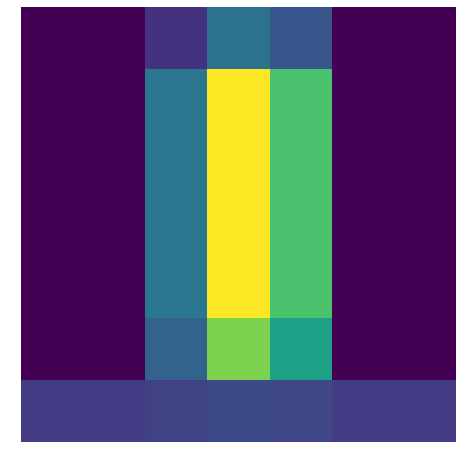

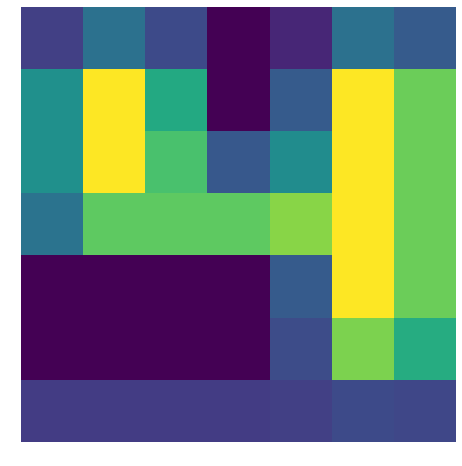

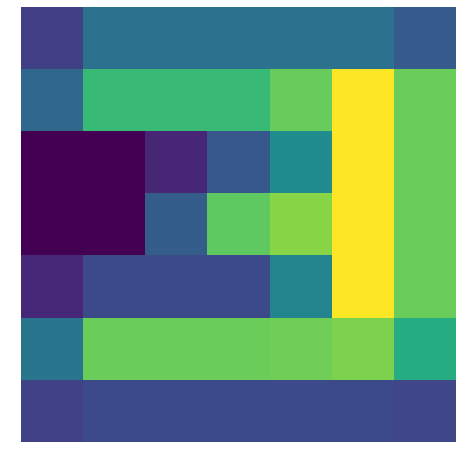

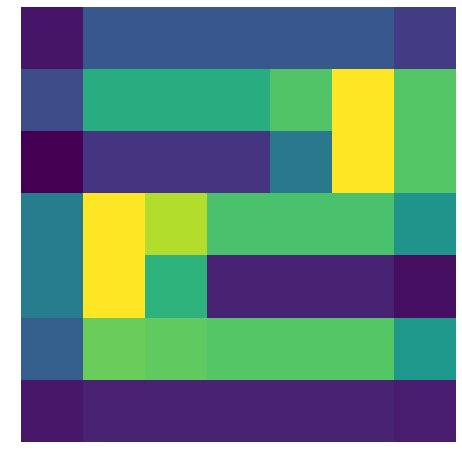

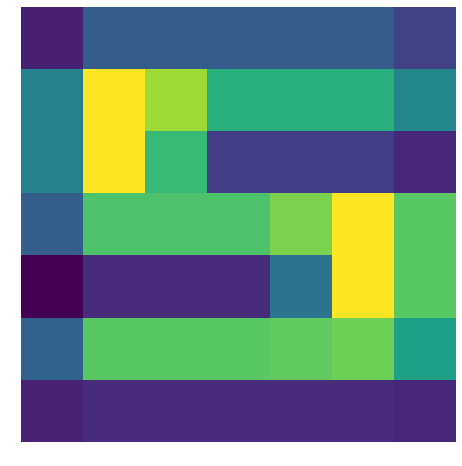

In [4]:
episodes = 1
env = gym.make("Breakout-v0")
init = env.reset()

for i in range(episodes):
    print("Welcome to AI Breakout!")
    print("Starting Test Game...\n")

    
    game = True
    LIVES = []
    while game:
        
        action = env.action_space.sample()
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        LIVES.append(lives)
        
        if done:
            
            LIVES = np.unique(np.array(LIVES), axis=0)
            
            for i in LIVES:
                plot_state(i.reshape(7,7))
            game = False
            observation = env.reset()
                             
        else:
            pass
            
         

In [5]:
env = gym.make("Breakout-v0")
init = env.reset()

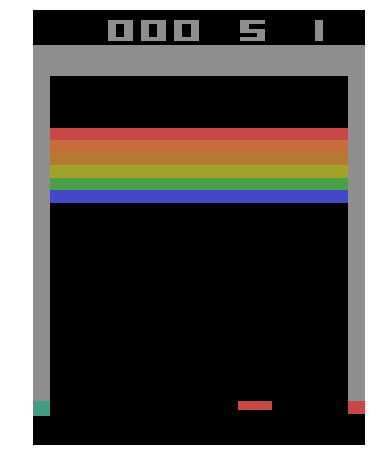

In [6]:
plot_state(init)

In [7]:
init.shape

(210, 160, 3)

In [8]:
I = process_obs(init)[0]

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [9]:
I.shape

(84, 84, 1)

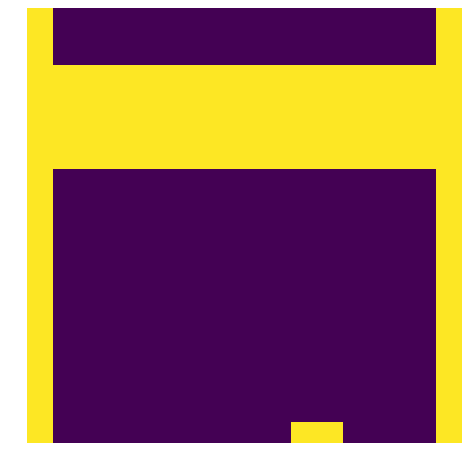

In [10]:
plot_state(I.reshape(84,84))

In [11]:
env.action_space

Discrete(4)

In [12]:
inp = Input(shape=(84,84,4))
x = Conv2D(16, (8,8), strides=4, activation="relu", input_shape=(84,84,4))(inp)
x = Conv2D(32, (4,4), strides=2, activation="relu")(x)
x = Flatten()(x)
x = Dense(256,  activation="relu")(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.01, patience=2, mode = min, verbose = 1)]
model.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["mae"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               663808    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
_________________________________________________________________
None

/Users/samwilliams/homebrew/lib/python3.7/site-packages/keras/callbacks.py:1086: RuntimeWarning: Learning Rate Plateau Reducing mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [13]:
LIFE = {}
LIFE["1"] = LIVES[0]
LIFE["2"] = LIVES[3]
LIFE["3"] = LIVES[2]
LIFE["4"] = LIVES[1]
LIFE["5"] = LIVES[4]

In [14]:
for i,j in LIFE.items():
    print(i)

1
2
3
4
5


In [15]:
full_episode_history = {"state" : np.zeros(shape=(1000000,84,84,4)),\
                        "reward" : np.zeros(shape=(1000000,)),\
                        "action": np.zeros(shape=(1000000,)), \
                        "Q": np.zeros(shape=(1000000,4))}

In [16]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 5000
episode_scores = []
total_frames = 0
epsilon = 1.0
gamma = 0.99
done = False

for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...\n".format(i, episodes))
    
    sum = 0
    frame = 1
    game = True
    LIVES = []
    observation_batch = []
    reward_batch = []
    episode_history = {"state" : np.array([]), "reward" : np.array([]), "action": np.array([]), "Q": np.array([])}

    while game: 
        if (frame == 1):
            action = 1              
        else:
            if (frame - 1) % 4 == 0:
                rand = np.random.uniform(0,1)
                if  rand < epsilon:
                    action = env.action_space.sample()
                else:
                    observation = np.expand_dims(episode_history["state"][-1],0)
                    action = np.argmax(model.predict(observation))
                
                if len(episode_history["state"]) > 2:
                    if np.array_equal(episode_history["state"][-1], episode_history["state"][-2]):
                        action = 1
                    else:
                        pass
                else:
                    pass
                observation_batch = []
                reward_batch = []
                
            else:
                pass
            
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        
        if len(LIVES) == 0:
            LIVES.append(lives)
            loss = 0
        else:
            if np.array_equal(LIVES[-1], lives):
                loss = 0
            else:
                LIVES.append(lives)
                loss = 0
                
        observation_batch.append(observation)
        reward_batch.append(10*reward+loss)        
        
        if (frame % 4 == 0):
            if frame == 4:
                episode_history["state"] = np.concatenate([i for i in observation_batch], axis=-1)
                episode_history["state"] = np.expand_dims(episode_history["state"],0)

            else:
                obs = np.concatenate([i for i in observation_batch], axis=-1)
                obs = np.expand_dims(obs,0)
                episode_history["state"] = np.concatenate([episode_history["state"], obs], axis=0)

            episode_history["reward"] = np.concatenate([episode_history["reward"], np.array([np.sum(reward_batch)])], axis = 0)  
            episode_history["action"] = np.concatenate([episode_history["action"], np.array([action])], axis=0)
         
        sum += reward
        frame += 1
        
        if done:
            total_frames += episode_history["state"].shape[0]
            for j,k in enumerate(episode_history["reward"][::-1]):
                
                if j == 0:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1])] = k
                    Q = val
                else:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1-j])] = k + gamma*np.max(Q[-1])
                    Q = np.concatenate([Q,val], axis = 0)
                    
            Q = Q[::-1]
            episode_history["Q"] = Q
            
            full_episode_history["state"][total_frames - episode_history["state"].shape[0]: total_frames,:,:,:] = episode_history["state"]
            full_episode_history["reward"][total_frames - episode_history["state"].shape[0]: total_frames] = episode_history["reward"]
            full_episode_history["action"][total_frames - episode_history["state"].shape[0]: total_frames] = episode_history["action"]
            full_episode_history["Q"][total_frames - episode_history["state"].shape[0]: total_frames,:] = episode_history["Q"]

            print("Training the model from a random batch...")

            rand = np.random.choice(range(total_frames), size=32)
            inp = full_episode_history["state"][rand]
            target = full_episode_history["Q"][rand]
            model.fit(inp, target, epochs = 5, batch_size=8, verbose=0)
            print("Total game score was: {}".format(int(sum)))
            print("Epsilon: {}\n".format(epsilon))
            
            observation = env.reset()
            observation, lives = process_obs(observation)
            episode_scores.append(int(sum))
            
            
            m = -9e-7
            epsilon = round(m*total_frames +1,3)
            if epsilon < 0.1:
                epsilon = 0.1
            game = False
            frame = 0
                             
        else:
            pass
            
         

Welcome to AI Breakout!
Starting Game 1 of 5000...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Training the model from a random batch...
Total game score was: 0
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 2 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 3 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 4 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 5 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 6 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 7 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 8 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 1

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 63 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 64 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 65 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 66 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 67 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 68 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 69 of 5000...

Training the model from a random batch...
Total game sc

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.993

Welcome to AI Breakout!
Starting Game 124 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.993

Welcome to AI Breakout!
Starting Game 125 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.993

Welcome to AI Breakout!
Starting Game 126 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.993

Welcome to AI Breakout!
Starting Game 127 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.993

Welcome to AI Breakout!
Starting Game 128 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.992

Welcome to AI Breakout!
Starting Game 129 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.992

Welcome to AI Breakout!
Starting Game 130 of 5000...

Training the model from a random batch...
Total 

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 185 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 186 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 187 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 188 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 189 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 190 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 191 of 5000...

Training the model from a random batch...
Total 

Total game score was: 0
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 245 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 246 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 247 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 248 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 249 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 250 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 251 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.985

Welcome 

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.982

Welcome to AI Breakout!
Starting Game 306 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.982

Welcome to AI Breakout!
Starting Game 307 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.982

Welcome to AI Breakout!
Starting Game 308 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.982

Welcome to AI Breakout!
Starting Game 309 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 310 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 311 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 312 of 5000...

Training the model from a random batch...
Total 

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 367 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 368 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 369 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 370 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 371 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 372 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 373 of 5000...

Training the model from a random batch...
Total 

Total game score was: 1
Epsilon: 0.975

Welcome to AI Breakout!
Starting Game 427 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.975

Welcome to AI Breakout!
Starting Game 428 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.975

Welcome to AI Breakout!
Starting Game 429 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.975

Welcome to AI Breakout!
Starting Game 430 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 431 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 432 of 5000...

Training the model from a random batch...
Total game score was: 7
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 433 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.974

Welcome 

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 488 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 489 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 490 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 491 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 492 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 493 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 494 of 5000...

Training the model from a random batch...
Total 

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 549 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 550 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 551 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 552 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 553 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 554 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.967

Welcome to AI Breakout!
Starting Game 555 of 5000...

Training the model from a random batch...
Total 

Total game score was: 4
Epsilon: 0.964

Welcome to AI Breakout!
Starting Game 609 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.964

Welcome to AI Breakout!
Starting Game 610 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.964

Welcome to AI Breakout!
Starting Game 611 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.964

Welcome to AI Breakout!
Starting Game 612 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.963

Welcome to AI Breakout!
Starting Game 613 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.963

Welcome to AI Breakout!
Starting Game 614 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.963

Welcome to AI Breakout!
Starting Game 615 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.963

Welcome 

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 670 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 671 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 672 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 673 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 674 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 675 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.96

Welcome to AI Breakout!
Starting Game 676 of 5000...

Training the model from a random batch...
Total game sc

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.957

Welcome to AI Breakout!
Starting Game 731 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 732 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 733 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 734 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 735 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 736 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.956

Welcome to AI Breakout!
Starting Game 737 of 5000...

Training the model from a random batch...
Total 

Total game score was: 3
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 791 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 792 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 793 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 794 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 795 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 796 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.953

Welcome to AI Breakout!
Starting Game 797 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.953

Welcome 

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 852 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 853 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 854 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 855 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 856 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 857 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.949

Welcome to AI Breakout!
Starting Game 858 of 5000...

Training the model from a random batch...
Total 

Total game score was: 1
Epsilon: 0.946

Welcome to AI Breakout!
Starting Game 912 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.946

Welcome to AI Breakout!
Starting Game 913 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.946

Welcome to AI Breakout!
Starting Game 914 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.946

Welcome to AI Breakout!
Starting Game 915 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.945

Welcome to AI Breakout!
Starting Game 916 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.945

Welcome to AI Breakout!
Starting Game 917 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.945

Welcome to AI Breakout!
Starting Game 918 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.945

Welcome 

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.942

Welcome to AI Breakout!
Starting Game 973 of 5000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.942

Welcome to AI Breakout!
Starting Game 974 of 5000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.942

Welcome to AI Breakout!
Starting Game 975 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.942

Welcome to AI Breakout!
Starting Game 976 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.942

Welcome to AI Breakout!
Starting Game 977 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.942

Welcome to AI Breakout!
Starting Game 978 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.941

Welcome to AI Breakout!
Starting Game 979 of 5000...

Training the model from a random batch...
Total 

Total game score was: 2
Epsilon: 0.938

Welcome to AI Breakout!
Starting Game 1033 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.938

Welcome to AI Breakout!
Starting Game 1034 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.938

Welcome to AI Breakout!
Starting Game 1035 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.938

Welcome to AI Breakout!
Starting Game 1036 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.938

Welcome to AI Breakout!
Starting Game 1037 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.938

Welcome to AI Breakout!
Starting Game 1038 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.938

Welcome to AI Breakout!
Starting Game 1039 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.938

W

Total game score was: 0
Epsilon: 0.935

Welcome to AI Breakout!
Starting Game 1093 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.935

Welcome to AI Breakout!
Starting Game 1094 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.935

Welcome to AI Breakout!
Starting Game 1095 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.935

Welcome to AI Breakout!
Starting Game 1096 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.935

Welcome to AI Breakout!
Starting Game 1097 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.934

Welcome to AI Breakout!
Starting Game 1098 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.934

Welcome to AI Breakout!
Starting Game 1099 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.934

W

Total game score was: 1
Epsilon: 0.931

Welcome to AI Breakout!
Starting Game 1153 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.931

Welcome to AI Breakout!
Starting Game 1154 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.931

Welcome to AI Breakout!
Starting Game 1155 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.931

Welcome to AI Breakout!
Starting Game 1156 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.931

Welcome to AI Breakout!
Starting Game 1157 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.931

Welcome to AI Breakout!
Starting Game 1158 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.931

Welcome to AI Breakout!
Starting Game 1159 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.931

W

Total game score was: 3
Epsilon: 0.928

Welcome to AI Breakout!
Starting Game 1213 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.928

Welcome to AI Breakout!
Starting Game 1214 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.928

Welcome to AI Breakout!
Starting Game 1215 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.928

Welcome to AI Breakout!
Starting Game 1216 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.928

Welcome to AI Breakout!
Starting Game 1217 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.927

Welcome to AI Breakout!
Starting Game 1218 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.927

Welcome to AI Breakout!
Starting Game 1219 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.927

W

Total game score was: 1
Epsilon: 0.924

Welcome to AI Breakout!
Starting Game 1273 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.924

Welcome to AI Breakout!
Starting Game 1274 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.924

Welcome to AI Breakout!
Starting Game 1275 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.924

Welcome to AI Breakout!
Starting Game 1276 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.924

Welcome to AI Breakout!
Starting Game 1277 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.924

Welcome to AI Breakout!
Starting Game 1278 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.924

Welcome to AI Breakout!
Starting Game 1279 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.924

W

Total game score was: 1
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1333 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1334 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1335 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1336 of 5000...

Training the model from a random batch...
Total game score was: 7
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1337 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1338 of 5000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.921

Welcome to AI Breakout!
Starting Game 1339 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.921

W

Total game score was: 2
Epsilon: 0.917

Welcome to AI Breakout!
Starting Game 1393 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.917

Welcome to AI Breakout!
Starting Game 1394 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.917

Welcome to AI Breakout!
Starting Game 1395 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.917

Welcome to AI Breakout!
Starting Game 1396 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.917

Welcome to AI Breakout!
Starting Game 1397 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.917

Welcome to AI Breakout!
Starting Game 1398 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.917

Welcome to AI Breakout!
Starting Game 1399 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.917

W

Total game score was: 1
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1453 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1454 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1455 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1456 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1457 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1458 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.914

Welcome to AI Breakout!
Starting Game 1459 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.914

W

Total game score was: 1
Epsilon: 0.91

Welcome to AI Breakout!
Starting Game 1513 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.91

Welcome to AI Breakout!
Starting Game 1514 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.91

Welcome to AI Breakout!
Starting Game 1515 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.91

Welcome to AI Breakout!
Starting Game 1516 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.91

Welcome to AI Breakout!
Starting Game 1517 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.91

Welcome to AI Breakout!
Starting Game 1518 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.91

Welcome to AI Breakout!
Starting Game 1519 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.91

Welcome t

Total game score was: 1
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1573 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1574 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1575 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1576 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.907

Welcome to AI Breakout!
Starting Game 1577 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.906

Welcome to AI Breakout!
Starting Game 1578 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.906

Welcome to AI Breakout!
Starting Game 1579 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.906

W

Total game score was: 1
Epsilon: 0.903

Welcome to AI Breakout!
Starting Game 1633 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.903

Welcome to AI Breakout!
Starting Game 1634 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.903

Welcome to AI Breakout!
Starting Game 1635 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.903

Welcome to AI Breakout!
Starting Game 1636 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.903

Welcome to AI Breakout!
Starting Game 1637 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.903

Welcome to AI Breakout!
Starting Game 1638 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.903

Welcome to AI Breakout!
Starting Game 1639 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.903

W

Total game score was: 0
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1693 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1694 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1695 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1696 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1697 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1698 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.9

Welcome to AI Breakout!
Starting Game 1699 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.899

Welcome to AI B

Total game score was: 3
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1753 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1754 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1755 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1756 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1757 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1758 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.896

Welcome to AI Breakout!
Starting Game 1759 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.896

W

Total game score was: 0
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1813 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1814 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1815 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1816 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1817 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.893

Welcome to AI Breakout!
Starting Game 1818 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.892

Welcome to AI Breakout!
Starting Game 1819 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.892

W

Total game score was: 0
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1873 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1874 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1875 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1876 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1877 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1878 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.889

Welcome to AI Breakout!
Starting Game 1879 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.889

W

Total game score was: 1
Epsilon: 0.886

Welcome to AI Breakout!
Starting Game 1933 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.886

Welcome to AI Breakout!
Starting Game 1934 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.886

Welcome to AI Breakout!
Starting Game 1935 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.886

Welcome to AI Breakout!
Starting Game 1936 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.886

Welcome to AI Breakout!
Starting Game 1937 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.886

Welcome to AI Breakout!
Starting Game 1938 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.886

Welcome to AI Breakout!
Starting Game 1939 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.886

W

Total game score was: 3
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1993 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1994 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1995 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1996 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1997 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1998 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.882

Welcome to AI Breakout!
Starting Game 1999 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.882

W

Total game score was: 0
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2053 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2054 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2055 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2056 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2057 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2058 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.879

Welcome to AI Breakout!
Starting Game 2059 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.879

W

Total game score was: 1
Epsilon: 0.876

Welcome to AI Breakout!
Starting Game 2113 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2114 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2115 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2116 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2117 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2118 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.875

Welcome to AI Breakout!
Starting Game 2119 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.875

W

Total game score was: 1
Epsilon: 0.872

Welcome to AI Breakout!
Starting Game 2173 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.872

Welcome to AI Breakout!
Starting Game 2174 of 5000...

Training the model from a random batch...
Total game score was: 9
Epsilon: 0.872

Welcome to AI Breakout!
Starting Game 2175 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.872

Welcome to AI Breakout!
Starting Game 2176 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.872

Welcome to AI Breakout!
Starting Game 2177 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.872

Welcome to AI Breakout!
Starting Game 2178 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.871

Welcome to AI Breakout!
Starting Game 2179 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.871

W

Total game score was: 1
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2233 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2234 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2235 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2236 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2237 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2238 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.868

Welcome to AI Breakout!
Starting Game 2239 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.868

W

Total game score was: 3
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2293 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2294 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2295 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2296 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2297 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2298 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.864

Welcome to AI Breakout!
Starting Game 2299 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.864

W

Total game score was: 3
Epsilon: 0.861

Welcome to AI Breakout!
Starting Game 2353 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.861

Welcome to AI Breakout!
Starting Game 2354 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.861

Welcome to AI Breakout!
Starting Game 2355 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.861

Welcome to AI Breakout!
Starting Game 2356 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.861

Welcome to AI Breakout!
Starting Game 2357 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.86

Welcome to AI Breakout!
Starting Game 2358 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.86

Welcome to AI Breakout!
Starting Game 2359 of 5000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.86

Welc

Total game score was: 1
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2413 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2414 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2415 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2416 of 5000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2417 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2418 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.857

Welcome to AI Breakout!
Starting Game 2419 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.856

W

Total game score was: 2
Epsilon: 0.853

Welcome to AI Breakout!
Starting Game 2473 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.853

Welcome to AI Breakout!
Starting Game 2474 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.853

Welcome to AI Breakout!
Starting Game 2475 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.853

Welcome to AI Breakout!
Starting Game 2476 of 5000...

Training the model from a random batch...
Total game score was: 7
Epsilon: 0.853

Welcome to AI Breakout!
Starting Game 2477 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.853

Welcome to AI Breakout!
Starting Game 2478 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.853

Welcome to AI Breakout!
Starting Game 2479 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.853

W

Total game score was: 3
Epsilon: 0.85

Welcome to AI Breakout!
Starting Game 2533 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.849

Welcome to AI Breakout!
Starting Game 2534 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.849

Welcome to AI Breakout!
Starting Game 2535 of 5000...

Training the model from a random batch...
Total game score was: 7
Epsilon: 0.849

Welcome to AI Breakout!
Starting Game 2536 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.849

Welcome to AI Breakout!
Starting Game 2537 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.849

Welcome to AI Breakout!
Starting Game 2538 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.849

Welcome to AI Breakout!
Starting Game 2539 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.849

We

Total game score was: 1
Epsilon: 0.846

Welcome to AI Breakout!
Starting Game 2593 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.846

Welcome to AI Breakout!
Starting Game 2594 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.846

Welcome to AI Breakout!
Starting Game 2595 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.846

Welcome to AI Breakout!
Starting Game 2596 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.846

Welcome to AI Breakout!
Starting Game 2597 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.846

Welcome to AI Breakout!
Starting Game 2598 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.846

Welcome to AI Breakout!
Starting Game 2599 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.846

W

Total game score was: 2
Epsilon: 0.842

Welcome to AI Breakout!
Starting Game 2653 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.842

Welcome to AI Breakout!
Starting Game 2654 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.842

Welcome to AI Breakout!
Starting Game 2655 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.842

Welcome to AI Breakout!
Starting Game 2656 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.842

Welcome to AI Breakout!
Starting Game 2657 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.842

Welcome to AI Breakout!
Starting Game 2658 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.842

Welcome to AI Breakout!
Starting Game 2659 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.842

W

Total game score was: 2
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2713 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2714 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2715 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2716 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2717 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2718 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.839

Welcome to AI Breakout!
Starting Game 2719 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.838

W

Total game score was: 1
Epsilon: 0.836

Welcome to AI Breakout!
Starting Game 2773 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.835

Welcome to AI Breakout!
Starting Game 2774 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.835

Welcome to AI Breakout!
Starting Game 2775 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.835

Welcome to AI Breakout!
Starting Game 2776 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.835

Welcome to AI Breakout!
Starting Game 2777 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.835

Welcome to AI Breakout!
Starting Game 2778 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.835

Welcome to AI Breakout!
Starting Game 2779 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.835

W

Total game score was: 4
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2833 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2834 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2835 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2836 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2837 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2838 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.832

Welcome to AI Breakout!
Starting Game 2839 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.832

W

Total game score was: 3
Epsilon: 0.828

Welcome to AI Breakout!
Starting Game 2893 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.828

Welcome to AI Breakout!
Starting Game 2894 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.828

Welcome to AI Breakout!
Starting Game 2895 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.828

Welcome to AI Breakout!
Starting Game 2896 of 5000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.828

Welcome to AI Breakout!
Starting Game 2897 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.828

Welcome to AI Breakout!
Starting Game 2898 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.828

Welcome to AI Breakout!
Starting Game 2899 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.828

W

Total game score was: 5
Epsilon: 0.825

Welcome to AI Breakout!
Starting Game 2953 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.825

Welcome to AI Breakout!
Starting Game 2954 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.824

Welcome to AI Breakout!
Starting Game 2955 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.824

Welcome to AI Breakout!
Starting Game 2956 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.824

Welcome to AI Breakout!
Starting Game 2957 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.824

Welcome to AI Breakout!
Starting Game 2958 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.824

Welcome to AI Breakout!
Starting Game 2959 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.824

W

Total game score was: 0
Epsilon: 0.821

Welcome to AI Breakout!
Starting Game 3013 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.821

Welcome to AI Breakout!
Starting Game 3014 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.821

Welcome to AI Breakout!
Starting Game 3015 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.821

Welcome to AI Breakout!
Starting Game 3016 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.821

Welcome to AI Breakout!
Starting Game 3017 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.821

Welcome to AI Breakout!
Starting Game 3018 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.821

Welcome to AI Breakout!
Starting Game 3019 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.82

We

Total game score was: 1
Epsilon: 0.817

Welcome to AI Breakout!
Starting Game 3073 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.817

Welcome to AI Breakout!
Starting Game 3074 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.817

Welcome to AI Breakout!
Starting Game 3075 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.817

Welcome to AI Breakout!
Starting Game 3076 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.817

Welcome to AI Breakout!
Starting Game 3077 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.817

Welcome to AI Breakout!
Starting Game 3078 of 5000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.817

Welcome to AI Breakout!
Starting Game 3079 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.817

W

Total game score was: 4
Epsilon: 0.814

Welcome to AI Breakout!
Starting Game 3133 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.814

Welcome to AI Breakout!
Starting Game 3134 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.814

Welcome to AI Breakout!
Starting Game 3135 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.814

Welcome to AI Breakout!
Starting Game 3136 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.814

Welcome to AI Breakout!
Starting Game 3137 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.814

Welcome to AI Breakout!
Starting Game 3138 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.813

Welcome to AI Breakout!
Starting Game 3139 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.813

W

Total game score was: 1
Epsilon: 0.81

Welcome to AI Breakout!
Starting Game 3193 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.81

Welcome to AI Breakout!
Starting Game 3194 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.81

Welcome to AI Breakout!
Starting Game 3195 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.81

Welcome to AI Breakout!
Starting Game 3196 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.81

Welcome to AI Breakout!
Starting Game 3197 of 5000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.81

Welcome to AI Breakout!
Starting Game 3198 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.81

Welcome to AI Breakout!
Starting Game 3199 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.81

Welcome t

Total game score was: 2
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3253 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3254 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3255 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3256 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3257 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.807

Welcome to AI Breakout!
Starting Game 3258 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.806

Welcome to AI Breakout!
Starting Game 3259 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.806

W

Total game score was: 0
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3313 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3314 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3315 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3316 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3317 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3318 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.803

Welcome to AI Breakout!
Starting Game 3319 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.803

W

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.8

Welcome to AI Breakout!
Starting Game 3374 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.799

Welcome to AI Breakout!
Starting Game 3375 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.799

Welcome to AI Breakout!
Starting Game 3376 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.799

Welcome to AI Breakout!
Starting Game 3377 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.799

Welcome to AI Breakout!
Starting Game 3378 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.799

Welcome to AI Breakout!
Starting Game 3379 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.799

Welcome to AI Breakout!
Starting Game 3380 of 5000...

Training the model from a random batch...
T

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3434 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3435 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3436 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3437 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3438 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3439 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.796

Welcome to AI Breakout!
Starting Game 3440 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3494 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3495 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3496 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3497 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.793

Welcome to AI Breakout!
Starting Game 3498 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.792

Welcome to AI Breakout!
Starting Game 3499 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.792

Welcome to AI Breakout!
Starting Game 3500 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.789

Welcome to AI Breakout!
Starting Game 3554 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.789

Welcome to AI Breakout!
Starting Game 3555 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.789

Welcome to AI Breakout!
Starting Game 3556 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.789

Welcome to AI Breakout!
Starting Game 3557 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.789

Welcome to AI Breakout!
Starting Game 3558 of 5000...

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.789

Welcome to AI Breakout!
Starting Game 3559 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.789

Welcome to AI Breakout!
Starting Game 3560 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.785

Welcome to AI Breakout!
Starting Game 3614 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.785

Welcome to AI Breakout!
Starting Game 3615 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.785

Welcome to AI Breakout!
Starting Game 3616 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.785

Welcome to AI Breakout!
Starting Game 3617 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.785

Welcome to AI Breakout!
Starting Game 3618 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.785

Welcome to AI Breakout!
Starting Game 3619 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.785

Welcome to AI Breakout!
Starting Game 3620 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.782

Welcome to AI Breakout!
Starting Game 3674 of 5000...

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.782

Welcome to AI Breakout!
Starting Game 3675 of 5000...

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.782

Welcome to AI Breakout!
Starting Game 3676 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.782

Welcome to AI Breakout!
Starting Game 3677 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.781

Welcome to AI Breakout!
Starting Game 3678 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.781

Welcome to AI Breakout!
Starting Game 3679 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.781

Welcome to AI Breakout!
Starting Game 3680 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.778

Welcome to AI Breakout!
Starting Game 3734 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.778

Welcome to AI Breakout!
Starting Game 3735 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.778

Welcome to AI Breakout!
Starting Game 3736 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.778

Welcome to AI Breakout!
Starting Game 3737 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.778

Welcome to AI Breakout!
Starting Game 3738 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.778

Welcome to AI Breakout!
Starting Game 3739 of 5000...

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.778

Welcome to AI Breakout!
Starting Game 3740 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.774

Welcome to AI Breakout!
Starting Game 3794 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.774

Welcome to AI Breakout!
Starting Game 3795 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.774

Welcome to AI Breakout!
Starting Game 3796 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.774

Welcome to AI Breakout!
Starting Game 3797 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.774

Welcome to AI Breakout!
Starting Game 3798 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.774

Welcome to AI Breakout!
Starting Game 3799 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.774

Welcome to AI Breakout!
Starting Game 3800 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.771

Welcome to AI Breakout!
Starting Game 3854 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.771

Welcome to AI Breakout!
Starting Game 3855 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.771

Welcome to AI Breakout!
Starting Game 3856 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.771

Welcome to AI Breakout!
Starting Game 3857 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.77

Welcome to AI Breakout!
Starting Game 3858 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.77

Welcome to AI Breakout!
Starting Game 3859 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.77

Welcome to AI Breakout!
Starting Game 3860 of 5000...

Training the model from a random batch...
To

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.767

Welcome to AI Breakout!
Starting Game 3914 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.767

Welcome to AI Breakout!
Starting Game 3915 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.767

Welcome to AI Breakout!
Starting Game 3916 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.767

Welcome to AI Breakout!
Starting Game 3917 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.767

Welcome to AI Breakout!
Starting Game 3918 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.767

Welcome to AI Breakout!
Starting Game 3919 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.767

Welcome to AI Breakout!
Starting Game 3920 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.764

Welcome to AI Breakout!
Starting Game 3974 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.764

Welcome to AI Breakout!
Starting Game 3975 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.763

Welcome to AI Breakout!
Starting Game 3976 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.763

Welcome to AI Breakout!
Starting Game 3977 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.763

Welcome to AI Breakout!
Starting Game 3978 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.763

Welcome to AI Breakout!
Starting Game 3979 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.763

Welcome to AI Breakout!
Starting Game 3980 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.76

Welcome to AI Breakout!
Starting Game 4034 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.76

Welcome to AI Breakout!
Starting Game 4035 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.76

Welcome to AI Breakout!
Starting Game 4036 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.76

Welcome to AI Breakout!
Starting Game 4037 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.76

Welcome to AI Breakout!
Starting Game 4038 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.76

Welcome to AI Breakout!
Starting Game 4039 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.76

Welcome to AI Breakout!
Starting Game 4040 of 5000...

Training the model from a random batch...
Total 

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.757

Welcome to AI Breakout!
Starting Game 4094 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.757

Welcome to AI Breakout!
Starting Game 4095 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.756

Welcome to AI Breakout!
Starting Game 4096 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.756

Welcome to AI Breakout!
Starting Game 4097 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.756

Welcome to AI Breakout!
Starting Game 4098 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.756

Welcome to AI Breakout!
Starting Game 4099 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.756

Welcome to AI Breakout!
Starting Game 4100 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4154 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4155 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4156 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4157 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4158 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4159 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.753

Welcome to AI Breakout!
Starting Game 4160 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.749

Welcome to AI Breakout!
Starting Game 4214 of 5000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.749

Welcome to AI Breakout!
Starting Game 4215 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.749

Welcome to AI Breakout!
Starting Game 4216 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.749

Welcome to AI Breakout!
Starting Game 4217 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.749

Welcome to AI Breakout!
Starting Game 4218 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.749

Welcome to AI Breakout!
Starting Game 4219 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.749

Welcome to AI Breakout!
Starting Game 4220 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.746

Welcome to AI Breakout!
Starting Game 4274 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.746

Welcome to AI Breakout!
Starting Game 4275 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.746

Welcome to AI Breakout!
Starting Game 4276 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.746

Welcome to AI Breakout!
Starting Game 4277 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.745

Welcome to AI Breakout!
Starting Game 4278 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.745

Welcome to AI Breakout!
Starting Game 4279 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.745

Welcome to AI Breakout!
Starting Game 4280 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.742

Welcome to AI Breakout!
Starting Game 4334 of 5000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.742

Welcome to AI Breakout!
Starting Game 4335 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.742

Welcome to AI Breakout!
Starting Game 4336 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.742

Welcome to AI Breakout!
Starting Game 4337 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.742

Welcome to AI Breakout!
Starting Game 4338 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.742

Welcome to AI Breakout!
Starting Game 4339 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.742

Welcome to AI Breakout!
Starting Game 4340 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.739

Welcome to AI Breakout!
Starting Game 4394 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.739

Welcome to AI Breakout!
Starting Game 4395 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.739

Welcome to AI Breakout!
Starting Game 4396 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.739

Welcome to AI Breakout!
Starting Game 4397 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.739

Welcome to AI Breakout!
Starting Game 4398 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.739

Welcome to AI Breakout!
Starting Game 4399 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.739

Welcome to AI Breakout!
Starting Game 4400 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.735

Welcome to AI Breakout!
Starting Game 4454 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.735

Welcome to AI Breakout!
Starting Game 4455 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.735

Welcome to AI Breakout!
Starting Game 4456 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.735

Welcome to AI Breakout!
Starting Game 4457 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.735

Welcome to AI Breakout!
Starting Game 4458 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.735

Welcome to AI Breakout!
Starting Game 4459 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.735

Welcome to AI Breakout!
Starting Game 4460 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.732

Welcome to AI Breakout!
Starting Game 4514 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.732

Welcome to AI Breakout!
Starting Game 4515 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.731

Welcome to AI Breakout!
Starting Game 4516 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.731

Welcome to AI Breakout!
Starting Game 4517 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.731

Welcome to AI Breakout!
Starting Game 4518 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.731

Welcome to AI Breakout!
Starting Game 4519 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.731

Welcome to AI Breakout!
Starting Game 4520 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.728

Welcome to AI Breakout!
Starting Game 4574 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.728

Welcome to AI Breakout!
Starting Game 4575 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.728

Welcome to AI Breakout!
Starting Game 4576 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.728

Welcome to AI Breakout!
Starting Game 4577 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.728

Welcome to AI Breakout!
Starting Game 4578 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.728

Welcome to AI Breakout!
Starting Game 4579 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.728

Welcome to AI Breakout!
Starting Game 4580 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.725

Welcome to AI Breakout!
Starting Game 4634 of 5000...

Training the model from a random batch...
Total game score was: 6
Epsilon: 0.724

Welcome to AI Breakout!
Starting Game 4635 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.724

Welcome to AI Breakout!
Starting Game 4636 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.724

Welcome to AI Breakout!
Starting Game 4637 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.724

Welcome to AI Breakout!
Starting Game 4638 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.724

Welcome to AI Breakout!
Starting Game 4639 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.724

Welcome to AI Breakout!
Starting Game 4640 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.721

Welcome to AI Breakout!
Starting Game 4694 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.721

Welcome to AI Breakout!
Starting Game 4695 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.721

Welcome to AI Breakout!
Starting Game 4696 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.721

Welcome to AI Breakout!
Starting Game 4697 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.721

Welcome to AI Breakout!
Starting Game 4698 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.721

Welcome to AI Breakout!
Starting Game 4699 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.72

Welcome to AI Breakout!
Starting Game 4700 of 5000...

Training the model from a random batch...


Training the model from a random batch...
Total game score was: 0
Epsilon: 0.717

Welcome to AI Breakout!
Starting Game 4754 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.717

Welcome to AI Breakout!
Starting Game 4755 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.717

Welcome to AI Breakout!
Starting Game 4756 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.717

Welcome to AI Breakout!
Starting Game 4757 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.717

Welcome to AI Breakout!
Starting Game 4758 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.717

Welcome to AI Breakout!
Starting Game 4759 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.717

Welcome to AI Breakout!
Starting Game 4760 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.714

Welcome to AI Breakout!
Starting Game 4814 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.714

Welcome to AI Breakout!
Starting Game 4815 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.714

Welcome to AI Breakout!
Starting Game 4816 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.714

Welcome to AI Breakout!
Starting Game 4817 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.714

Welcome to AI Breakout!
Starting Game 4818 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.714

Welcome to AI Breakout!
Starting Game 4819 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.714

Welcome to AI Breakout!
Starting Game 4820 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.711

Welcome to AI Breakout!
Starting Game 4874 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.711

Welcome to AI Breakout!
Starting Game 4875 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.711

Welcome to AI Breakout!
Starting Game 4876 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.71

Welcome to AI Breakout!
Starting Game 4877 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.71

Welcome to AI Breakout!
Starting Game 4878 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.71

Welcome to AI Breakout!
Starting Game 4879 of 5000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.71

Welcome to AI Breakout!
Starting Game 4880 of 5000...

Training the model from a random batch...
Tot

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.707

Welcome to AI Breakout!
Starting Game 4934 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.707

Welcome to AI Breakout!
Starting Game 4935 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.707

Welcome to AI Breakout!
Starting Game 4936 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.707

Welcome to AI Breakout!
Starting Game 4937 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.707

Welcome to AI Breakout!
Starting Game 4938 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.707

Welcome to AI Breakout!
Starting Game 4939 of 5000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.707

Welcome to AI Breakout!
Starting Game 4940 of 5000...

Training the model from a random batch...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.704

Welcome to AI Breakout!
Starting Game 4994 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.704

Welcome to AI Breakout!
Starting Game 4995 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.704

Welcome to AI Breakout!
Starting Game 4996 of 5000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.703

Welcome to AI Breakout!
Starting Game 4997 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.703

Welcome to AI Breakout!
Starting Game 4998 of 5000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.703

Welcome to AI Breakout!
Starting Game 4999 of 5000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.703

Welcome to AI Breakout!
Starting Game 5000 of 5000...

Training the model from a random batch...

In [20]:
print(full_episode_history["state"].shape)
print(episode_history["reward"].shape)
print(episode_history["action"].shape)
print(episode_history["Q"].shape)

(1000000, 84, 84, 4)
(54,)
(54,)
(54, 4)


In [22]:
print(episode_history["reward"][:])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [23]:
print(episode_history["action"])

[1. 3. 3. 3. 2. 3. 3. 1. 1. 2. 2. 3. 3. 0. 0. 1. 0. 2. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 0. 2. 3. 1. 2. 0. 0. 0. 1. 3. 3. 3. 0. 1. 1. 0. 1. 3.
 3. 1. 0. 0. 0. 0.]


In [24]:
print(episode_history["Q"][10])

[0.    0.    9.801 0.   ]


In [25]:
model.predict(np.expand_dims(episode_history["state"][10],0))

array([[ 1.8837874,  0.2643743,  9.2478075, -1.3039699]], dtype=float32)

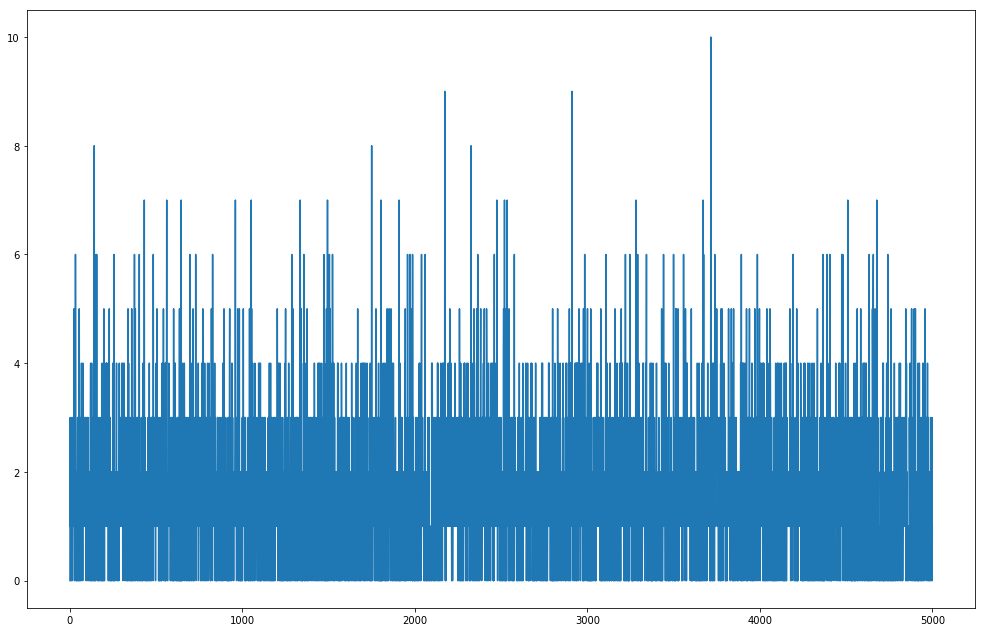

In [26]:
plt.figure(figsize=(17,11))
plt.plot(episode_scores)
plt.show()

# Saving Model

In [27]:
model.save("breakout-atari-rl.h5")

# Testing the Model

In [28]:
mod = load_model("breakout-atari-rl.h5")

In [32]:

env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 10
done = False
epsilon = 0


for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...".format(i, episodes))
    
    sum = 0
    frame = 1
    game = True
    observation_batch = []
    while game:
        
        if (frame == 1):
            action = 1              
        else:
            if (frame - 1) % 4 == 0:
                action = np.argmax(mod.predict(states))
                print(action)

                if np.array_equal(states[0][:84,:84,0], states[0][:84,:84,3]):
                    action = 1
                    print("Yes")
                else:
                    pass
                
                observation_batch = []                
            else:
                pass
            
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        observation_batch.append(observation)
        
        if (frame % 4 == 0):
            states = np.concatenate([i for i in observation_batch], axis=-1)
            states = np.expand_dims(states,0)


        sum += reward
        frame += 1
        time.sleep(0.03)
        env.render()

        if done:
            print("Total game score was: {}\n".format(int(sum)))
            observation = env.reset()
            observation, lives = process_obs(observation)
            game = False
env.close()        



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Welcome to AI Breakout!
Starting Game 1 of 10...
1
1
1
1
0
1
1
Yes
1
1
1
1
1
1
1
1
Yes
1
1
1
1
1
1
1
Yes
1
Yes
1
1
1
1
1
1
1
1
Yes
1
1
1
1
1
1
1
1
1
Yes
Total game score was: 0

Welcome to AI Breakout!
Starting Game 2 of 10...
1
1
1
1
1
1
1
Yes
1
1
1
1
1
1
1
1
Yes
1
1
1
1
1
1
1
1
Yes
1
1
1
1
1
1
1
1
Yes
1
1
1
0
1
1
1
1
Yes
Total game score was: 0

Welcome to AI Breakout!
Starting Game 3 of 10...
1
1
1
1
1
1
1
Yes
1
1
1
1
1
1
1
1
Yes
1
Yes
1
1
1
1
1
1
1
Yes
1
1
1
1
1
1
1
1
1
Yes
1
Yes
1
1
1
1
1
1
1
1
Yes
Total game score was: 0

Welcome to AI Breakout!
Starting Game 4 of 10...
1
1
1
1
1
1
1
1
Yes
1
1
1
1
1
1
1
Yes
1
Yes
1
1
1
1
1
1
1
1
Yes
1
Yes
1
1
1
1
1
1
1
Yes
1
Yes
1
1
1
1
1
1
1
1
Yes
Total game score was: 0

Welcome to AI Breakout!
Starting Game 5 of 10...
1
1
1
1
1
1
1
1
Yes
1
1
1
1
1
1
1
1
Yes
1
1
1
1


KeyboardInterrupt: 